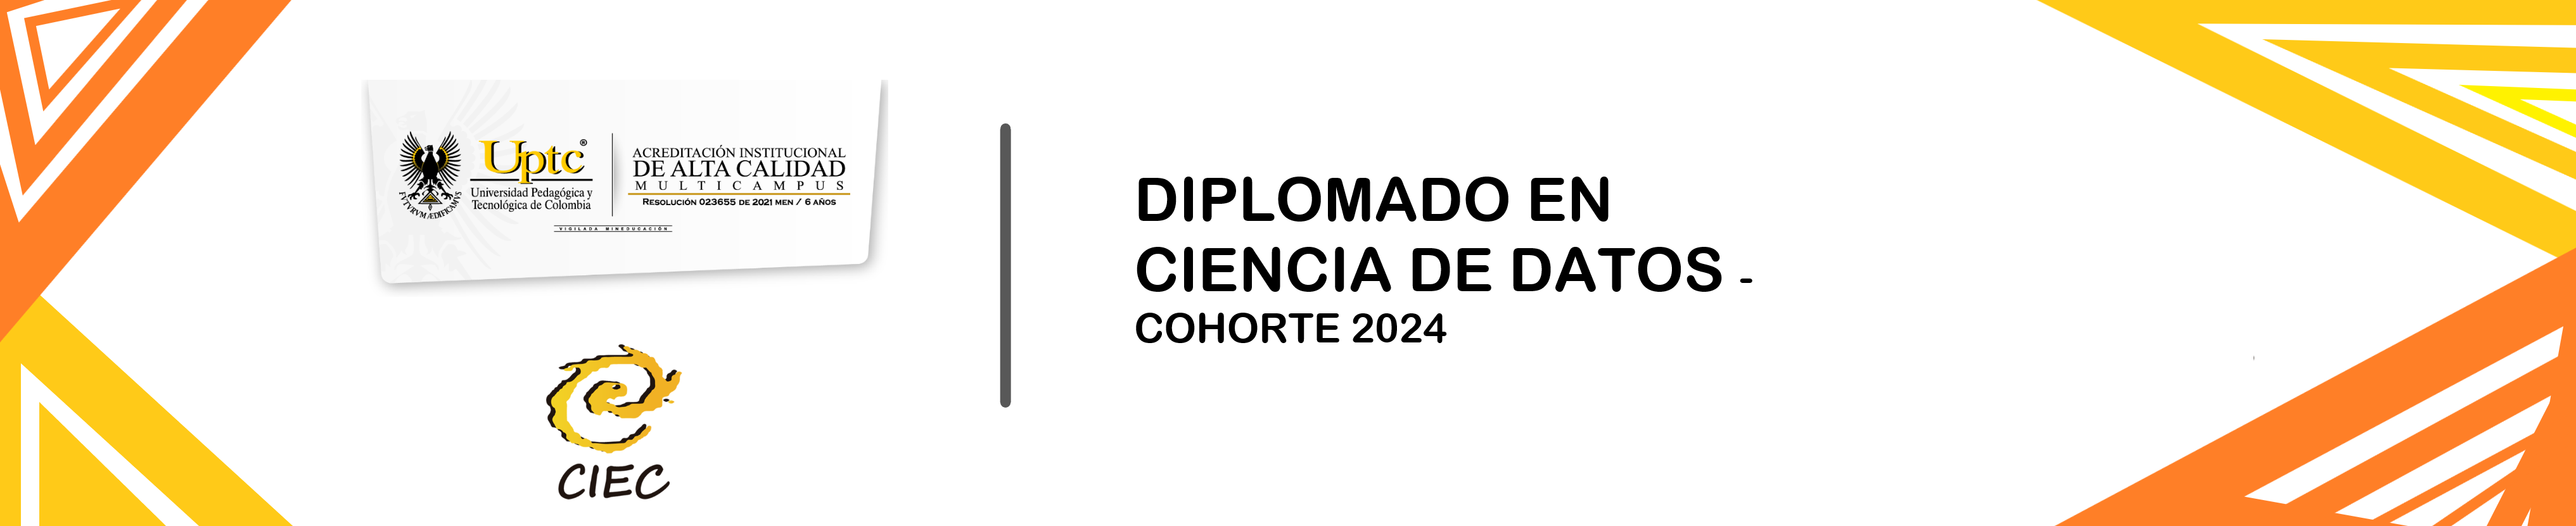

# **Proyecto 2: Análisis Exploratorio de Datos (EDA)**


Bienvenido al segundo proyecto guiado del curso de "*Análisis Esploratorio de Datos (EDA)*". Durante este proyecto, harémos uso de las herramientas de análisis exploratorio de datos vistas en clase y desarrollaremos un proyecto de EDA desde cero con base a un dataset de ejemplo en el cuál responderémos diferentes preguntas a cerca de nuestro conjunto de datos con base a las cinco fases básicas del proceso de EDA:

*   Detección de valores nulos y duplicados
*   Análisis univariado de variables numéricas
*   Análisis de variables categóricas
*   Análisis bivariado y de correlación
*   Análisis multivariado

En adición a lo anterior, realizaremos una serie de procedimientos de preprocesamiento de los datos dentro de los cuáles encontramos.

*  Numerización de variables categóricas
*  Imputación de valores nulos por medio del algoritmo KNN
*  Validación estadística de la inputación de valores
*  Balanceamiento de datos categóricos por oversampling y subsampling

---

# **1. Importación de datos y dependencias**

### 1.1. Dependencias

---
Dependencias

---

##### 1.1.1. Librerías principales

In [39]:
# Propósito general
import warnings
warnings.simplefilter(action='ignore')
# Manejo de datos
import numpy as np
import pandas as pd
from io import StringIO
# Visualización
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# EDA
import missingno
import statsmodels.api as sm
from sklearn.impute import KNNImputer
import scipy.stats as sts
from scipy.stats import ks_2samp
from imblearn.over_sampling import SMOTE
# Pipelines y preprocesamiento
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

##### 1.1.2. Utilidades

In [40]:
#--------------------------------------------------------------------------------
#--------------------------------- Histogram-Box --------------------------------
#--------------------------------------------------------------------------------

def histogram_box(dataframe, variable):
  df = dataframe
  fig, ax = plt.subplots(1,2,figsize=(14,5))
  # histogram_box plot

  sns.histplot(data=df, x=str(variable), kde=True, ax=ax[0])
  sns.boxplot(data=df, x=str(variable), ax=ax[1])

  # mean
  mean = df[str(variable)].mean()
  ax[0].axvline(mean, color='red')
  # stats-box
  variance = round(df[str(variable)].var(),2)
  kurtosis = round(df[str(variable)].kurt(),2)
  skewness = round(df[str(variable)].skew(),2)

  textstr = '\n'.join( (r'mean=%.2f' % (mean, ), r'Variance=%.2f' % (variance, ), r'Kurtosis=%.2f' % (kurtosis, ), r'Skewness=%.2f' % (skewness, )) )
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
  ax[0].text(0.05, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
  ax[0].set_title(f'Histogram of {variable}')
  ax[0].set_xlabel(f'{variable}')
  ax[0].set_ylabel("Frecuency")
  ax[0].grid(True)
  ax[1].set_title(f'Boxplot of {variable}')
  ax[1].set_xlabel(f'{variable}')
  ax[1].set_ylabel("Frecuencias")
  ax[1].grid(True)

  plt.subplots_adjust(hspace=0.5)
  plt.show()

In [41]:
#--------------------------------------------------------------------------------
#-------------------------- Percentage of null data -----------------------------
#--------------------------------------------------------------------------------

class data_processing:
  def __init__(self):
    pass

  # Percentage of null values
  def null_classifier(self,dataframe):
    series = dataframe.isnull().sum() * 100 / dataframe.shape[0]
    nulls  = {'Variable': series.index, 'Percentage of null values': series.values}
    nulls = pd.DataFrame(nulls).sort_values(by = 'Percentage of null values', ascending = False)
    return nulls

  # Simple column selector
  def column_selector(self, dataframe, column_names):
    df = dataframe
    selected_columns = [col for col in column_names if col in df.columns]
    selected_df = df[selected_columns]
    return selected_df

  # Column selector by null percentage
  def null_df_filter(self, dataframe, threshold):
    df = dataframe
    nulls = self.null_classifier(df)
    filtered = nulls[nulls['Percentage of null values'] < threshold]['Variable']
    df_filtered = df[filtered]
    return df_filtered

In [42]:
#--------------------------------------------------------------------------------
#----------------------------- Test de imputación -------------------------------
#--------------------------------------------------------------------------------

def imputation_test(original_dataframe, imputed_dataframe, problematic_columns):

  df_before = original_dataframe
  df_after = imputed_dataframe
  statistics = pd.DataFrame({})
  statistics['Item'] = ['t-test', 'p-value', 'ks_test', 'p_value_ks','observed mean', 'imputed mean','observed variance', 'imputed variance', 'mean difference', 'var difference']

  for column in problematic_columns:
    observed_values = df_before[column].dropna()
    imputed_values = df_after[column].dropna()

    mean_observed = observed_values.mean()
    mean_imputed = imputed_values.mean()
    var_observed = observed_values.var()
    imp_observed = imputed_values.var()
    var_difference = abs(var_observed - imp_observed)
    mean_difference = abs(mean_observed - mean_imputed)

    # two-sided t-test
    t_stat, p_value = sts.ttest_ind(observed_values, imputed_values, equal_var = False)
    # ks-test
    ks_stat, p_value_ks = ks_2samp(observed_values, imputed_values)
    statistics[column] = [t_stat, p_value, ks_stat, p_value_ks ,mean_observed, mean_imputed, var_observed, imp_observed, mean_difference, var_difference]

  return statistics

In [43]:
#--------------------------------------------------------------------------------
#---------- Visualizaciones especiales y validación de imputación ---------------
#--------------------------------------------------------------------------------

class plots:
    def __init__(self):
         pass

    def histogram_box(self, dataframe, variable):
         df = dataframe
         fig, ax = plt.subplots(1,2,figsize=(14,5))

         # histogram_box plot
         sns.histplot(data=df, x=str(variable), kde=True, ax=ax[0])
         sns.boxplot(data=df, x=str(variable))

         # mean
         mean = df[str(variable)].mean()
         ax[0].axvline(mean, color='red')

         # stats-box
         variance = round(df[str(variable)].var(),2)
         kurtosis = round(df[str(variable)].kurt(),2)
         skewness = round(df[str(variable)].skew(),2)

         textstr = '\n'.join( (r'mean=%.2f' % (mean, ), r'Variance=%.2f' % (variance, ), r'Kurtosis=%.2f' % (kurtosis, ), r'Skewness=%.2f' % (skewness, )) )
         props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
         ax[0].text(0.05, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='top', bbox=props)
         ax[0].set_title(f'Histogram of {variable}')

         ax[0].set_xlabel(f'{variable}')
         ax[0].set_ylabel("Frecuency")
         ax[0].grid(True)
         ax[1].set_title(f'Boxplot of {variable}')
         ax[1].set_xlabel(f'{variable}')
         ax[1].set_ylabel("Frecuencias")
         ax[1].grid(True)

         plt.subplots_adjust(hspace=0.5)

         plt.show()


class inputation_plots:

  def __init__(self):
    pass

  def plot_inputation_comparison(self, observed_df, imputed_df, problematic_columns, subplot_layout, size):
    rows, cols = subplot_layout
    r, c = rows, cols
    fig, axs = plt.subplots(rows,cols, figsize = size)

    def plot_function(position,obs_val, imp_val, col_name, x_limits):
      mean_obs = np.mean(obs_val)
      mean_imp = np.mean(imp_val)
      i , j = position[0] , position[1]
      ax = axs[i,j]
      sns.histplot(observed_values, label='Original',kde=True, color='blue', ax=ax)
      sns.histplot(imputed_values, label='Imputed',kde=True, color='orange', ax=ax)
      ax.axvline(mean_obs, color='black')
      ax.axvline(mean_imp, color='red')
      ax.set_title(f'Comparison for {column}')
      ax.set_xlabel(f'{column}')
      ax.set_ylabel('Frequency')
      ax.grid(True)
      ax.set_xlim(x_limits[0], x_limits[1])
      ax.legend()

    for k, column in enumerate(problematic_columns):

      observed_values = observed_df[column].dropna()
      imputed_values = imputed_df[column].dropna()
      limits = [min(observed_values.min(),imputed_values.min()),
                max(observed_values.max(),imputed_values.max())]

      i = rows - r
      j = cols - c

      plot_function([i,j], observed_values, imputed_values, column, limits)
      c -= 1
      if c > 0:
        r = r
      else:
        r -= 1
        c = cols

    plt.show()

### 1.2. Importación y descripción de los datos

---
Importación y descripción de los datos

---

El diccionario de los datos es el siguiente:

|Variable|Descripción|Tipología|
|---|---|---|
|PH| Indicador el estado ácido o alcalino del agua. Límite máximo permitido por la OMS es de 6.5 a 8.5|numérica|
|Dureza|Cantidad de sales de calcio y magnecio.|numérica|
|Sólidos|Sólidos totales disueltos (TDS). Es el parámetro más importante para el uso del agua, un alto valor indica alta mineralización. El límite deseable de TDS es de 500 mg/l y el límite máximo es de 1000 mg/l.|numérica|
|Cloraminas|Niveles de cloro y cloramina en el agua. Los valores hasta 4 miligramos por litro (4 partes por millón (ppm)) se consideran seguros en el agua potable.|numérica|
|Sulfatos|Niveles de sulfato, en la mayoría de los suministros de agua dulce, oscila entre 3 y 30 mg/l.|numérico|
|Coductividad|Concentración iónica en el agua determinada por la cantidad de sólidos disueltos en el agua. La CE (Conductividad Eléctrica) no debe superar los 400 micS/cm|numérico|
|Carbono_organico|Carbono Orgánico Total (COT), es la cantidad total de compuestos de carbono orgánico en el agua pura. |numérico|
|Trihalometanos|Los Trihalometanos (THM) son sustancias químicas que pueden encontrarse en el agua tratada con cloro. La concentración de THM en el agua potable varía según el nivel de materia orgánica en el agua, la cantidad de cloro necesaria para tratar el agua y la temperatura del agua que se está tratando. Los niveles de THM de hasta 80 ppm se considera seguros en el agua potable.|numérico|
|Turbidez|De pende de la cantidad de materia sólida presente en estado de suspensión. Es una medida de las propiedades de emisión de luz del agua y la prueba se utiliza para indicar la calidad de los vertidos con respecto a la materia coloidal.  El valor medio de turbidez obtenido para el Campus Wondo Gener es de 0.98 NTU e inferior al recomendado por la OMS dado por 5.00 NTU|categórica|


In [45]:
# Importación de los datos
path = 'https://raw.githubusercontent.com/AsorKy/Datasets/main/water_data.xlsx'
df_raw = pd.read_excel(path, sheet_name='in')
print('Dimensiones de los datos=', df_raw.shape)

Dimensiones de los datos= (3276, 10)


In [46]:
# Vista preliminar de los datos
df_raw.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
0,NaN,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,NO
1,3.72,129.42,18630.06,6.64,NaN,592.89,15.18,56.33,4.50,NO
2,8.10,224.24,19909.54,9.28,NaN,418.61,16.87,66.42,3.06,NO
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,NO
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,NO


Descripción de las variables del dataset.

In [47]:
# Tipos de variables en el dataset
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pH                2785 non-null   float64
 1   Dureza            3276 non-null   float64
 2   Sólidos           3276 non-null   float64
 3   Cloraminas        3276 non-null   float64
 4   Sulfatos          2495 non-null   float64
 5   Conductividad     3276 non-null   float64
 6   Carbono_orgánico  3276 non-null   float64
 7   Trihalometanos    3114 non-null   float64
 8   Turbidez          3276 non-null   float64
 9   Potabilidad       3276 non-null   object 
dtypes: float64(9), object(1)
memory usage: 256.1+ KB


In [48]:
df_raw.describe()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000
mean,7.080804,196.369481,22014.092415,7.122241,333.775784,426.205171,14.284921,66.396281,3.966731
std,1.594369,32.879680,8768.570852,1.583143,41.416864,80.824123,3.308232,16.174983,0.780354
min,0.000000,47.430000,320.940000,0.350000,129.000000,181.480000,2.200000,0.740000,1.450000
25%,6.090000,176.847500,15666.687500,6.130000,307.695000,365.735000,12.070000,55.847500,3.440000
50%,7.040000,196.965000,20927.830000,7.130000,333.070000,421.885000,14.220000,66.620000,3.955000
75%,8.060000,216.670000,27332.760000,8.112500,359.950000,481.790000,16.560000,77.337500,4.500000
max,14.000000,323.120000,61227.200000,13.130000,481.030000,753.340000,28.300000,124.000000,6.740000


La información anterior, nos permite reconocer que de las diez variables que conformal al dataset, nueve de ellas son de tipo numérico y solo una, la potabilidad, es de tipo categórico.

# **2. Análisis Exploratorio de Datos  (EDA)**

---
Análisis Exploratorio de los Datos

---

### 2.1. Detección de valores nulos y duplicados

---
Detección de valores nulos y duplicados

---


Una vez nos hemos asegurado que la carga de los datos ha sido exitosa y no parece haber errores de formato aparentes, procedemos a explorar los datos mediante visualizaciones y estadísticos principales. Para empezar, observemos la estadística descriptiva básica de nuestros datos numéricos y categóricos.

In [49]:
# Descripción estadística inicial de los datos numéricos
df = df_raw.copy()
df.describe()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000
mean,7.080804,196.369481,22014.092415,7.122241,333.775784,426.205171,14.284921,66.396281,3.966731
std,1.594369,32.879680,8768.570852,1.583143,41.416864,80.824123,3.308232,16.174983,0.780354
min,0.000000,47.430000,320.940000,0.350000,129.000000,181.480000,2.200000,0.740000,1.450000
25%,6.090000,176.847500,15666.687500,6.130000,307.695000,365.735000,12.070000,55.847500,3.440000
50%,7.040000,196.965000,20927.830000,7.130000,333.070000,421.885000,14.220000,66.620000,3.955000
75%,8.060000,216.670000,27332.760000,8.112500,359.950000,481.790000,16.560000,77.337500,4.500000
max,14.000000,323.120000,61227.200000,13.130000,481.030000,753.340000,28.300000,124.000000,6.740000


De los estadísticos principales podemos observar:
* Gracias a que la cantidad de regístros es 3276, y a que vemos que variables como el pH solo regístran 2785 regístros, empezamos a intuir que exísten valores faltantes dentro de nuestro conjunto de datos.

* En promedio, el pH de las muestras tomadas se encuentran dentro del rango aceptado  (6.5 - 8.5), no obstante, vemos que métricas como el Q3 y el valor máximo, se encuentran muy por encima de lo considerado como potable. Así pues, solo hasta el Q2 (mediana) de las muestras se encuentran dentro del rango potable.

* En promedio, los valores de sólidos se encuentran muy por encima (el doble) de lo considerado como aceptable. Vemos que en general las muéstras de agua contienen altos contenidos de sólidos ya que incluso desde el Q1, todos los valores de los cuartiles superan el rango aceptado, el cuál, según el diccionario de los datos, se encuentra entre 500 mg/l y 1000 mg/l.

* En general, tanto el valor promedio como los los tres cuartiles del nivel de cloraminas se encuentra muy por encima de lo aceptado, el cuál según el diccionario de los datos, corresponde a 4ppm.

* En general, tanto el valor promedio como los los tres cuartiles del nivel de sulfatos se encuentra muy por encima de lo aceptado, el cuál según el diccionario de los datos, corresponde a 30 mg/l.

* En cuanto a la Conductividad, el promerio se encuentra un poco por encima de lo aceptado como potable, y en general, los datos contienen una alta conductividad. Esto se evidencia ya que solo hasta el Q1 los datos poseen un valor de conductividad aceptable.

* En general, los Trihalometanos se encuentran por debajo del límite el cuál según el diccionario de los datos, corresponde a 80 ppm. Podemos evidenciarlo a partir de los estadísticos principales ya que tanto el promedio, como los datos hasta el Q3 se encuentran por debajo del límite.

* Con respecto a la turbidez, en general los datos se encuentran dentro del rango permitído por la OMS (5 NTU) pero solo hasta antes del Q1, los datos poseen el nivel de turbidez aceptable según el CWG.


Una vez hemos estudiado de manera general los datos numéricos, el análisis inicial de los datos categóricos nos dice que los datos no están balanceados y que es la categoría ```NO``` es la clasificación de potabilidad predominante. Conclusión que es tambíen deducida a partir de los estadísticos principales de las variables numéricas. Esto nos dice que solo el 60% de los datos registrados corresponden a muestras de aguas NO potables.



In [50]:
# Descripción estadística inicial de datos categóricos
df.describe(include='object')

,Potabilidad
count,3276
unique,2
top,NO
freq,1998


No obstante, ¿estas observaciones iniciales son acertadas?. Para contestar ésta pregunta, tenemos que determinar si dentro del dataset exísten valores nulos por columna para descartar la posibilidad de que nuestras observaciones estén sesgadas debido a la presencia de valores ausentes.


In [52]:
# Número de valores nulos por columna
tot = len(df)
nulos = (df.isnull().sum()/tot) * 100
nulidad = pd.DataFrame( {'Variable':nulos.index, 'Porcentaje de Nulidad': nulos.values} )
nulidad

,Variable,Porcentaje de Nulidad
0,pH,14.987790
1,Dureza,0.000000
2,Sólidos,0.000000
3,Cloraminas,0.000000
4,Sulfatos,23.840049
5,Conductividad,0.000000
6,Carbono_orgánico,0.000000
7,Trihalometanos,4.945055
8,Turbidez,0.000000
9,Potabilidad,0.000000


Al encontrar el número de valores nulos y determinar el porcentaje de nulidad (porcentaje de datos nulos), vemos que tenemos tres variables con presencia de valores nulos, donde de mayor a menor cantidad de nulidad se tiene las siguientes variables:

1. Sulfatos
2. pH
3. Trihalometanos

Dentro del conocimiento del autor del presente proyecto, es conocido que humbrales tales como 30% y 40% de nulidad son suficientes para considerar descartar una variable según el contexto del problema en cuestión. Con base a esto, ya que todas las variables con valores nulos no sobrepasan el humbral del 30%, conservaremos todas las variables problemáticas y procederemos más adelante a emplear técnicas de imputación de datos.

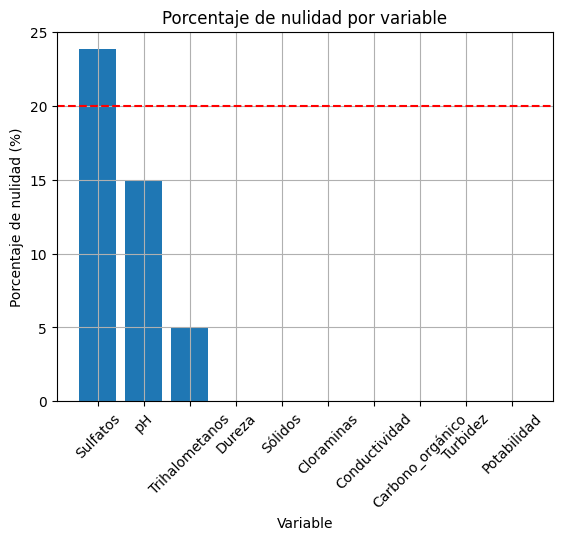

In [54]:
# Grafico de barras del porcentaje de nulidad
nulidad = nulidad.sort_values(by='Porcentaje de Nulidad', ascending=False)

plt.bar(
    nulidad['Variable'],
    nulidad['Porcentaje de Nulidad']
)

plt.axhline(y=20, color='red', linestyle='dashed', label='Threshold')

plt.xlabel('Variable')
plt.ylabel('Porcentaje de nulidad (%)')
plt.title('Porcentaje de nulidad por variable')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Ahora, procedemos a responder la pregunta ¿exíste un número importante de duplicados?. La respuesta a esta pregunta es NO exísten regístros duplicados dentro de nuestros datos.

In [55]:
# Numero de duplicados
n_duplicados = df.duplicated().sum()
porcentaje_duplicados = (n_duplicados / len(df)) * 100

print('El número de duplicados es = ', n_duplicados)
print('Porcentaje de duplicados es =', porcentaje_duplicados)

El número de duplicados es =  0
Porcentaje de duplicados es = 0.0


In [56]:
df_sin_nulos = df.dropna()
df_sin_nulos.shape

(2011, 10)

In [59]:
df_sin_duplicados = df.drop_duplicates()
df_sin_duplicados.shape

(3276, 10)

### 2.2. Preprocesamiento de los datos

##### 2.2.1. Transformación de variables categóricas

---
Transformación de variables categóricas

---

Antes de realizar la imputación de los datos, es necesrio convertir las variables categóricas a numéricas. Para ello, emplearemos la estrategia one-hot-encoder ya que la ventada de esta transformación es que no establece una jerarquía implicita a la conversión como si ocurre en el OrdinalEncoder. A demás, este acercamiento es apropiado debido a que solo necesitamos convertir una sola variable categórica binaria, lo que significa que al realizar la transformación OneHot no agregaríamos ninguna dimensión extra a nuestros datos ni una relación ordinal, ya que al ser Potabilidad una variable categórica binaria, bastaría con realizar la transformación `SI -> 1` y `NO -> 0`.

In [60]:
# One hot encoder
df_enc = df.copy()

codificacion = {'SI': 1, 'NO':0 }

df_enc['Potabilidad'] = df_enc['Potabilidad'].map(codificacion)
df_enc.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
0,NaN,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,0
1,3.72,129.42,18630.06,6.64,NaN,592.89,15.18,56.33,4.50,0
2,8.10,224.24,19909.54,9.28,NaN,418.61,16.87,66.42,3.06,0
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,0
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,0


##### 2.2.2. Imputación de valores nulos

---
Imputación de valores nulos

---

Una vez hemos realizado la numerización de los datos, procederémos a manejar los datos nulos mediante técnicas de imputación por modelos. Ésto debido a que en primer lugar, las variables categóricas del problema no presentan ausencias así que no será necesario emplear técnicas como imputación por el más frecuente. Más aún, técnicas como imputación por promedio en los datos numéricos no suelen ser demasiado realistas.
Así pues, en la presente sección emplearemos la técnica de imputación por medio del modelo KNN regresor de modo tal que los valores a imputar serán deducidos a partir de la similaridad del regístro con otros regístros en el dataset.
Por defecto, el imputador KNN emplea los 5 regístros mas similares para imputar los valores en las columnas donde exísten ausencias.

In [61]:
df.columns

Index(['pH', 'Dureza', 'Sólidos', 'Cloraminas', 'Sulfatos', 'Conductividad',
       'Carbono_orgánico', 'Trihalometanos', 'Turbidez', 'Potabilidad'],
      dtype='object')

In [62]:
df_test = df_enc.copy()
mean = df_test['Sulfatos'].mean()
df_test['Sulfatos'] = df_test['Sulfatos'].fillna(mean)
df_test.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
0,NaN,204.89,20791.32,7.30,368.520000,564.31,10.38,86.99,2.96,0
1,3.72,129.42,18630.06,6.64,333.775784,592.89,15.18,56.33,4.50,0
2,8.10,224.24,19909.54,9.28,333.775784,418.61,16.87,66.42,3.06,0
3,8.32,214.37,22018.42,8.06,356.890000,363.27,18.44,100.34,4.63,0
4,9.09,181.10,17978.99,6.55,310.140000,398.41,11.56,32.00,4.08,0


In [63]:
tot = len(df_test)
nulos = (df_test.isnull().sum()/tot) * 100
nulidad = pd.DataFrame( {'Variable':nulos.index, 'Porcentaje de Nulidad': nulos.values} )

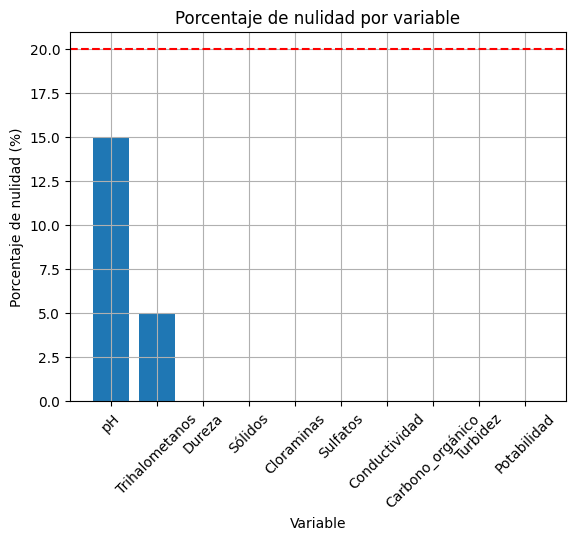

In [64]:
# Grafico de barras del porcentaje de nulidad
nulidad = nulidad.sort_values(by='Porcentaje de Nulidad', ascending=False)

plt.bar(
    nulidad['Variable'],
    nulidad['Porcentaje de Nulidad']
)

plt.axhline(y=20, color='red', linestyle='dashed', label='Threshold')

plt.xlabel('Variable')
plt.ylabel('Porcentaje de nulidad (%)')
plt.title('Porcentaje de nulidad por variable')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [71]:
# Función de imputación por algoritmo KNN
from sklearn.impute import KNNImputer

def knn_imputator(dataframe, k = 5):
  df = dataframe.copy()
  knn = KNNImputer(n_neighbors=k)
  df = pd.DataFrame(knn.fit_transform(df), columns = df.columns)
  return df

In [73]:
# Imputación de valores por medio del algoritmo KNN
df_knn = knn_imputator(df_enc, k=6)
df_knn.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
0,7.091667,204.89,20791.32,7.30,368.520000,564.31,10.38,86.99,2.96,0.0
1,3.720000,129.42,18630.06,6.64,336.128333,592.89,15.18,56.33,4.50,0.0
2,8.100000,224.24,19909.54,9.28,333.553333,418.61,16.87,66.42,3.06,0.0
3,8.320000,214.37,22018.42,8.06,356.890000,363.27,18.44,100.34,4.63,0.0
4,9.090000,181.10,17978.99,6.55,310.140000,398.41,11.56,32.00,4.08,0.0


In [70]:
df_raw.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
0,NaN,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,NO
1,3.72,129.42,18630.06,6.64,NaN,592.89,15.18,56.33,4.50,NO
2,8.10,224.24,19909.54,9.28,NaN,418.61,16.87,66.42,3.06,NO
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,NO
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,NO


Corroboramos a continuación que la imputación fué exitosa.

In [74]:
# Verificación de nulidad después de imputación de valores
df_knn.isnull().sum()

pH                  0
Dureza              0
Sólidos             0
Cloraminas          0
Sulfatos            0
Conductividad       0
Carbono_orgánico    0
Trihalometanos      0
Turbidez            0
Potabilidad         0
dtype: int64

##### 2.2.2. Verificación de validez de la imputación

---
Verificación de validez de la imputación

---

Una vez hemos realizado la imputación de los datos, realicemos un breve análisis para verificar que los datos no hayan cambiado sustancialmente después de la imputación y descartar que el método haya generado sesgos cambiando la distribución de los datos.

Para realizar el análisis visual, se emplea el constructor ```inputation_plots()```, el cual se encuentra dentro del notebook complementario al presente llamado ```visuals```, el cual nos permitirá comparar las distribuciones de las variables imputadas antes y después de la imputación.



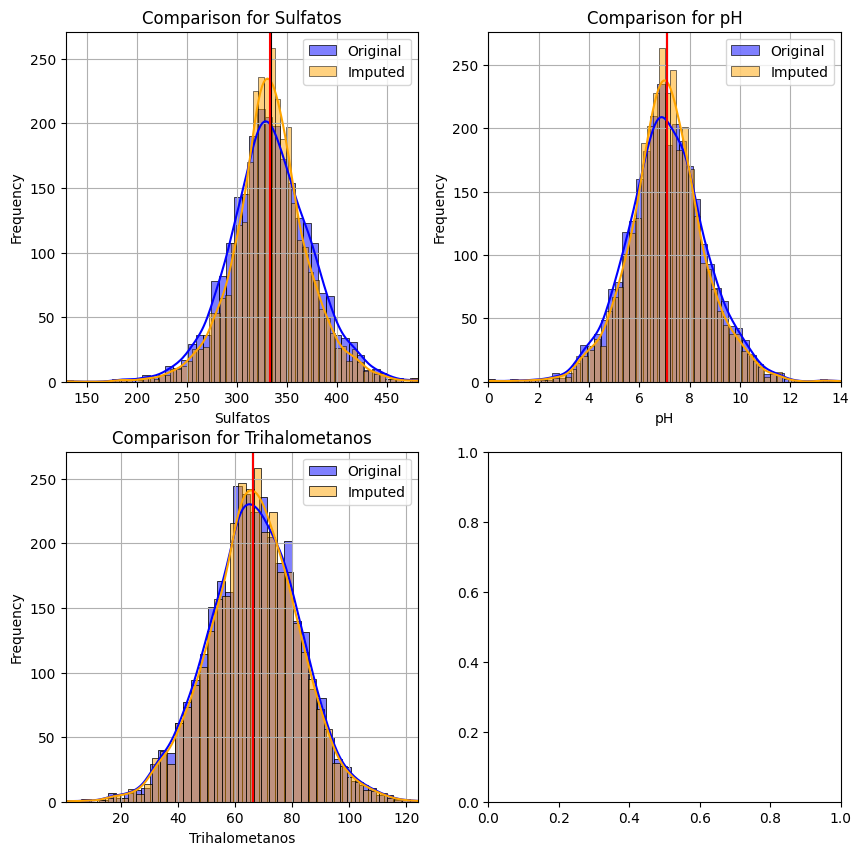

In [75]:
# Comparación de distribuciónes de las variables imputadas antes y después de la imputación
imputer_plot = inputation_plots()
problematic_columns = ['Sulfatos','pH','Trihalometanos']
imputer_plot.plot_inputation_comparison(df_enc, df_knn,problematic_columns , (2,2), (10,10))

Vemos en los graficos anteriores que el método de imputación parece ser exitoso, ya que no cambia sustancialmente la distribución de los datos y éstas variables conservan su forma de distribución similar a una distribución normal. Note entonces que es para las variables "Sulfatos" y "pH" en donde más diferencias (aunque leves) exísten entre las distribuciones, lo cuál puede explicarse a que estas dos son las variables que más imputación necesitan, por ende, una mayor cantidad de regístros "artificiales" han sido ingresados a los datos aumentando el conteo de datos en la parte central de la distribución.

No obstante note que los promedios, simbolizados por las líneas verticales "roja" y "negra" respectivamente correspondientes a las distribuciones imputadas y originales, se alínean casi a la perfección y no se evidencia ningún corrimiento de la distribución imputada con respecto a la distribución original. La única leve diferencia entre ambas distribuciones es un mayor número de conteo de valores en la parte central de la distribución, haciendo que la distribución imputada se encuentre ligeramente por encima de la distribución original en la parte central de la campana.

Por otra parte, dentro de la sección de dependencias presente en el presente notebook, se encuentra la función `imputation_test` la cual es una función construida para ejecutar diferentes test estadísticos de testeo de hipotesis la cual usaremos a continuación para determinar si las distribuciones antes y después de la imputación, presentan diferencias significativas. Para ello, tengamos en cuenta lo siguiente:

1. **Hipótesis Nula (H0)**: La hipótesis nula es que **no hay diferencia** significativa entre las distribuciones original e imputada, lo que significa que el método de imputación no introduce sesgo.

2. **Hipótesis Alternativa (H1)**: La hipótesis alternativa es que **hay una diferencia significativa** entre las distribuciones, lo que indica que el método de imputación introduce sesgo.

3. **Interpretación del p-value**: El p-value es la probabilidad de observar una diferencia tan grande o más grande entre las distribuciones original e imputada, si la hipótesis nula fuera verdadera. Por lo tanto, un p-value bajo indica que la diferencia observada es poco probable de haber ocurrido por casualidad bajo la hipótesis nula.

Si el p-value es menor que un nivel de significancia predefinido (por ejemplo, 0.05), entonces rechazamos la hipótesis nula y concluimos que hay evidencia suficiente para afirmar que hay una diferencia significativa entre las distribuciones. En este caso, podríamos decir que el método de imputación introduce sesgo.

Si el p-value es mayor que el nivel de significancia, no hay suficiente evidencia para rechazar la hipótesis nula. En este caso, no podemos concluir que el método de imputación introduce sesgo significativo en la distribución.

In [77]:
# Validación de hipótesis para imputación por knn
problematic_columns = ['Sulfatos', 'pH', 'Trihalometanos']
imp_test = imputation_test(df, df_test, problematic_columns)
imp_test

,Item,Sulfatos,pH,Trihalometanos
0,t-test,-5.453969e-14,0.000000,0.000000
1,p-value,1.000000e+00,1.000000,1.000000
2,ks_test,1.215413e-01,0.000000,0.000000
3,p_value_ks,1.096928e-18,1.000000,1.000000
4,observed mean,3.337758e+02,7.080804,66.396281
5,imputed mean,3.337758e+02,7.080804,66.396281
6,observed variance,1.715357e+03,2.542014,261.630070
7,imputed variance,1.306290e+03,2.542014,261.630070
8,mean difference,5.684342e-14,0.000000,0.000000
9,var difference,4.090667e+02,0.000000,0.000000


In [76]:
# Validación de hipótesis para imputación por knn
problematic_columns = ['Sulfatos', 'pH', 'Trihalometanos']
knn_test = imputation_test(df, df_knn, problematic_columns)
knn_test

,Item,Sulfatos,pH,Trihalometanos
0,t-test,0.128904,0.038403,-0.039450
1,p-value,0.897439,0.969368,0.968533
2,ks_test,0.046321,0.029609,0.011416
3,p_value_ks,0.004401,0.139102,0.983329
4,observed mean,333.775784,7.080804,66.396281
5,imputed mean,333.639934,7.079271,66.412085
6,observed variance,1715.356589,2.542014,261.630070
7,imputed variance,1386.259144,2.229151,250.512112
8,mean difference,0.135850,0.001533,0.015804
9,var difference,329.097445,0.312862,11.117957


Podemos observar de la tabla anterior que el p-value del t-test para las tres variables es superior a 0.05, por ende, el método de imputación por KNN es exitoso ya que no hay evidencia suficiente para concluir que exíste un sesgo introducido por la imputación.
Más aún, se evidencia que la diferencia de los promedios para los tres casos es casi nulo y la diferencia en las varianzas es pequeña, por ende, este método es adecuado para procesar los datos nulos.

### 2.2. Análisis univariado de variables numéricas

---
Análisis de Variables numéricas

---

Ya que no exísten valores nulos en nuestras variables, procedemos con el análisis univariado de nuestro dataset. Para empezar, observemos las distribuciones de las variables numéricas contínuas y para la variable `'cnt'` e intentemos detectar posibles valores atípicos o outliers. Para ésto, emplearemos una visualización de histograma y boxplot mediante la función `histogram_box`, presente en la sección de utilidades 1.1.2. del presente notebook.

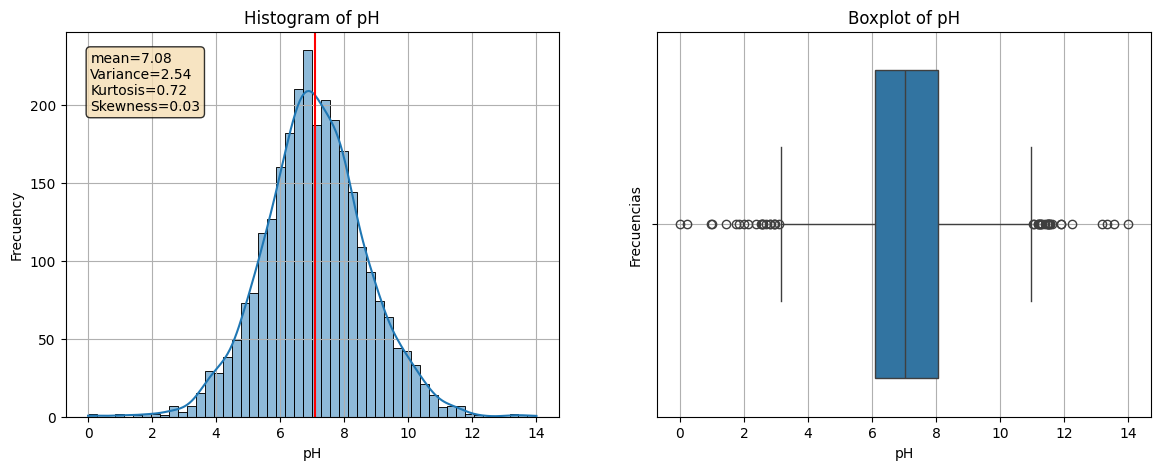

In [79]:
# Distribución (histograma) de la variable cantidad de Ph
histogram_box(df, 'pH')

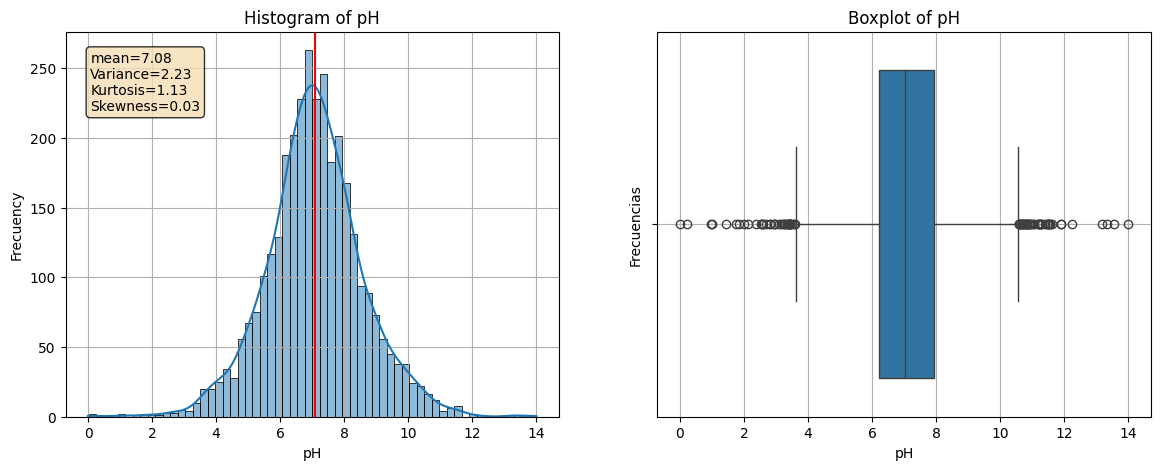

In [78]:
# Distribución (histograma) de la variable cantidad de Ph
histogram_box(df_knn, 'pH')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* El comportamiento de la variable PH es muy similar a una distribución normal.
* El centro de los datos, su promedio y mediana, se encuentra justo en el centro del rango permitido de PH 6.5 - 8.5. Lo cual insinúa que la mayoría de datos posee un valor aceptable como potable y exíste una pequeña cantidad de datos con ph extremo hacia arriba o abajo, es decir, o muy alto o muy bajo.
* Exíste una cantidad considerable de valores atípicos pero que no es superior o comparable al conjunto de datos centrados en el valor promedio.
* Lo anterior nos indíca que exíste una candidad escasa de muestras de agua muy pura, y una cantidad escasa de muestras de agua altamente contaminadas.
* La distribución es simétrica, baja varianza y gran concentración al rededor del valor medio.

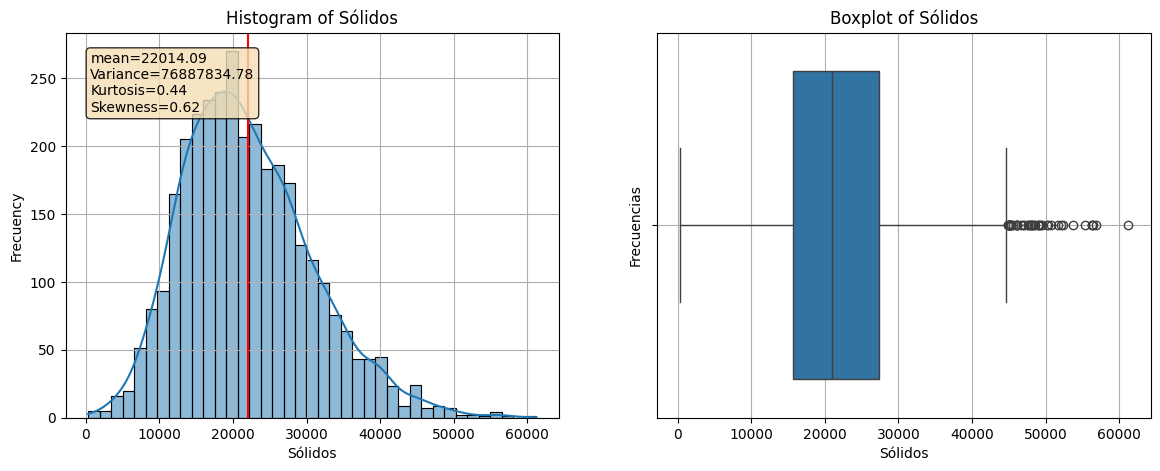

In [80]:
# Distribución (histograma) de la variable solidos
histogram_box(df_knn, 'Sólidos')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* El comportamiento de la variable Solidos presenta un pequeño sesgo positivo, hacia la derecha.
* El promedio de los datos se encuentra por encima del valor recomendado de sólidos disueltos 500mg/l - 1000mg/l.
* Exíste una cantidad considerable de valores atípicos pero que no es superior o comparable al conjunto de datos centrados en el valor promedio hacia la derecha, es decir, exíste una cantidad de muestras de agua con una alta concentración de sólidos disueltos.
* La concentración de los valores es cercana a la concentración mesocurtica, es decir, los valores no estan fuertemente concentrados en un rango estreco central de valores.


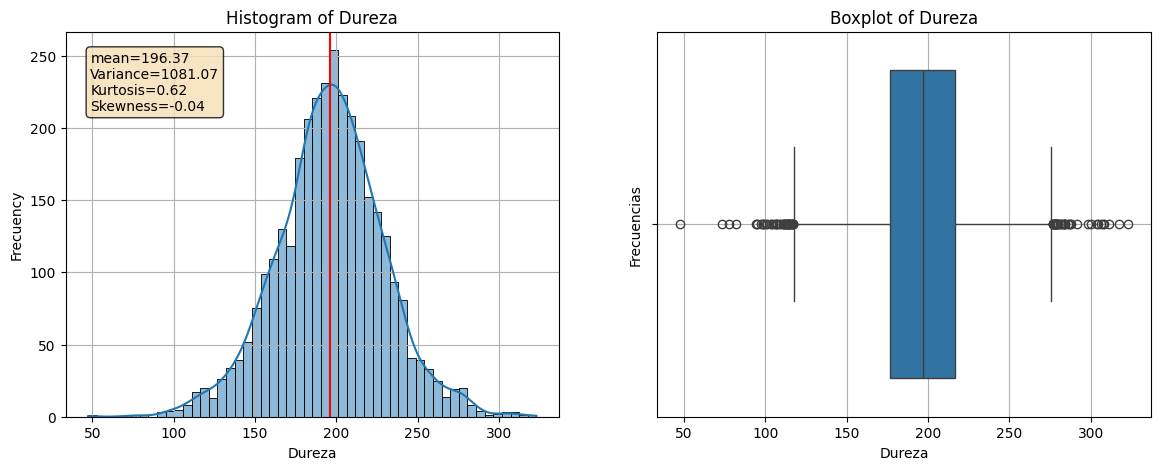

In [81]:
# Distribución (histograma) de la variable cantidad de dureza
histogram_box(df_knn, 'Dureza')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* El comportamiento de la variable Dureza es muy similar a una distribución normal.
* Es demasiado probable encontrar muestras de agua con alto contenido de sales y magnesio.
* La distribución es simétrica, alta varianza y baja concentración al rededor del valor medio.
* La concentración de valores tiende a comportarse leptocurticamente, es decir, exíste una gran cantidad de datos cuyos valores se encuentran en torno a un rango estrecho de valores centrados en el promedio de los datos.

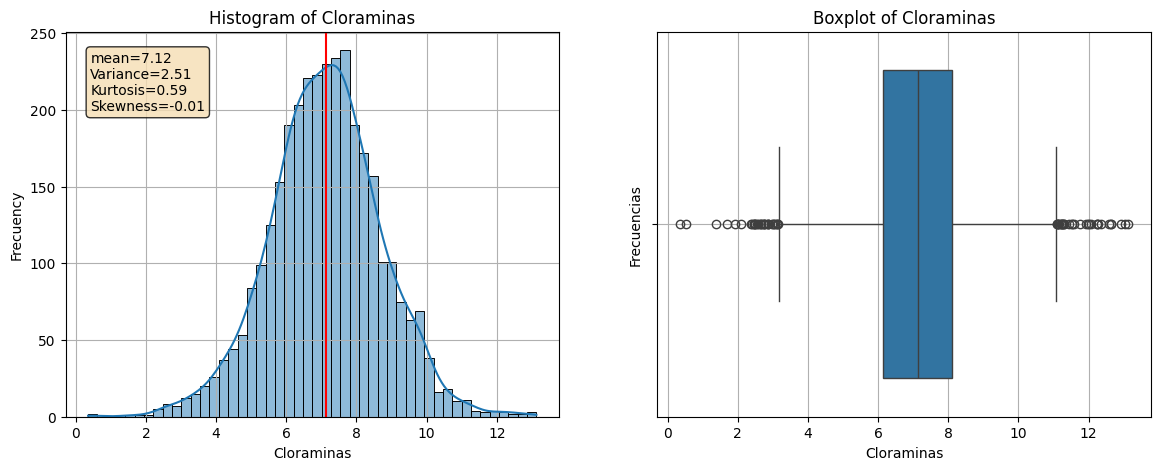

In [82]:
# Distribución (histograma) de la variable cantidad de Cloraminas
histogram_box(df_knn, 'Cloraminas')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* El comportamiento de la variable Cloraminas es muy similar a una distribución normal.
* Se puede observar que la distribución se encuentra centrada entre 6 y 8, niveles superiores al nivel de cloramina considerado como seguro. Esto quiere decir que la mayoría de los datos se encuentran al rededor de valores NO seguros de cloro y cloraminas, por ende, es muy probable que las muestras de agua tomadas sean en su mayoría NO potables.
* Exíste una varianza pequeña en los datos y una kurtosis pequeña pero positiva, lo cual indica que la distribución tiende a tener una concentración leptocúrtica.

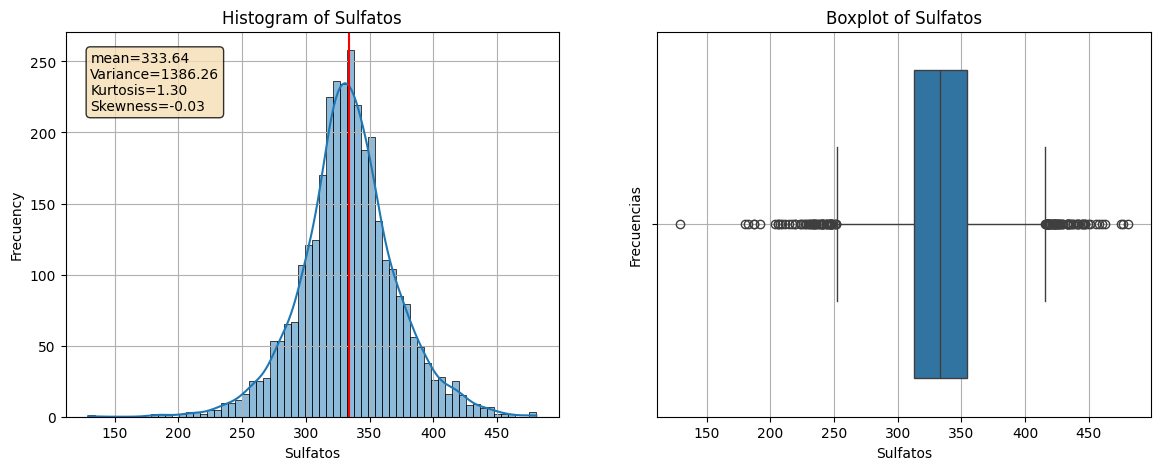

In [83]:
# Distribución (histograma) de la variable cantidad de Cloraminas
histogram_box(df_knn, 'Sulfatos')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* El comportamiento de la variable Sulfatos es muy similar a una distribución normal.
* Se puede observar que la distribución se encuentra centrada en el valor de concentración de sulfatos igual a 333 mg/l, nivel inseguro o no apropiado de sulfato. En general, la concentración ideal de sulfato se encuentra entre 3 mg/l y 30 mg/l. No obstante el nivel seguro de concentración de sulfato es de 250 mg/l, por ende, esta variable nos dice que la gran mayoría de las muestras de agua son consideradas como NO potables.
* La distribución es leptocurtica, lo que indica que existe una marcada concentración de los valores en un rango estrecho al rededor del valor central de la distribución.

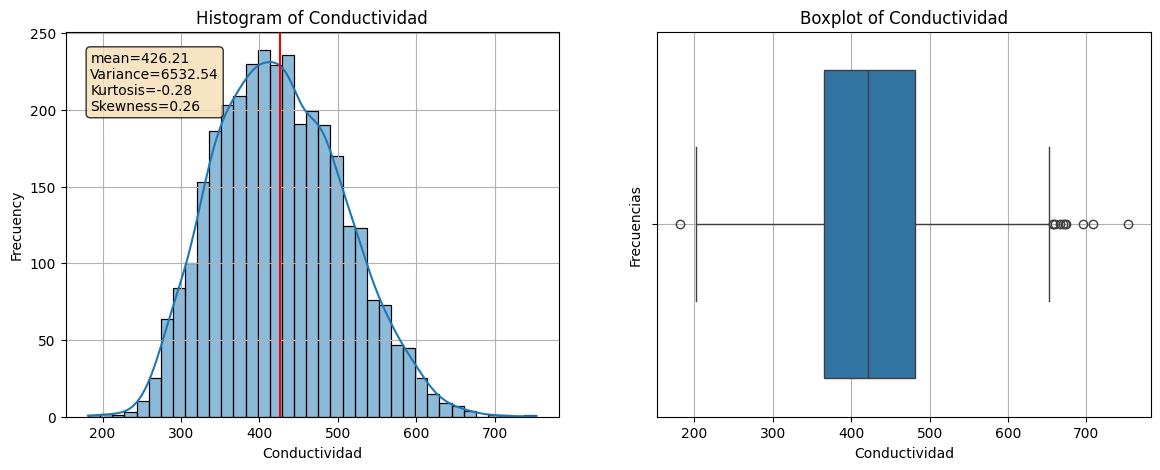

In [84]:
# Distribución (histograma) de la variable conductividad
histogram_box(df_knn, 'Conductividad')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* El comportamiento de la variable Conductividad es muy similar a una distribución normal.
* Se puede observar que la distribución se encuentra centrada en el valor de conductividad de 426, valor ligeramente superor al valor límite de conductividad de agua potable, asi que a pesar de que la distribución presenta un leve sesgo positivo indicando que la mayor concentración de valores de conductividad se encuentra en valores bajos de conductividad, el bajo nivel de kurtosis el cual es mesocurtico, indica que exíste una concentración de valores en un rango amplio. Si observamos la distribución, podemos ver que la mayoria de valores se encuentra entre 300 y 500, valores altos y no aceptados. Por ende, se puede ver que la mayoría de las muestras NO son potables.


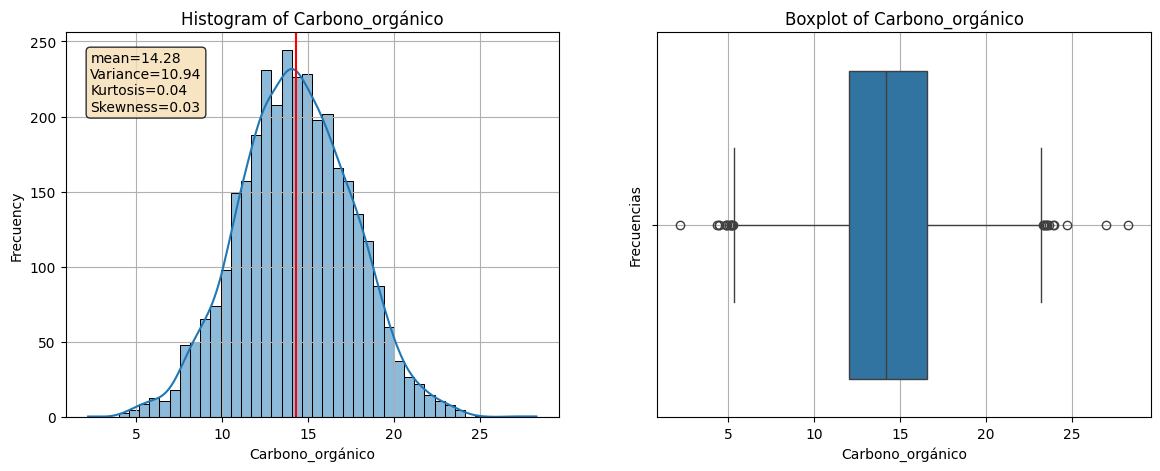

In [85]:
# Distribución (histograma) de la variable carbono orgánico
histogram_box(df_knn, 'Carbono_orgánico')

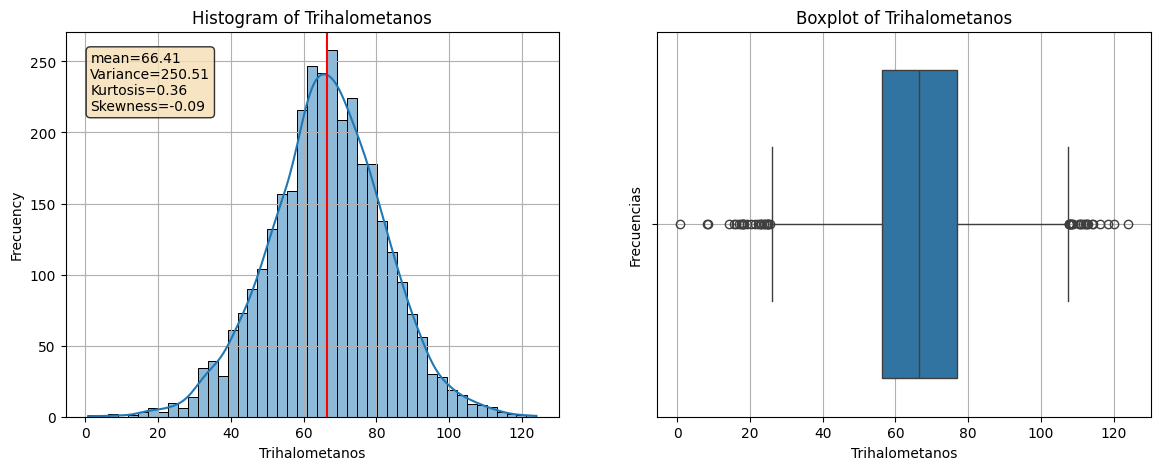

In [87]:
# Distribución (histograma) de la variable Trihalometanos
histogram_box(df_knn, 'Trihalometanos')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* El comportamiento de la variable Thrihalometanos es muy similar a una distribución normal.
* Se puede observar que la distribución se encuentra centrada en el valor de concentración de 66, valor cercano al límite de aceptabilidad de concentración el cuál es 80. Esto nos indica que al ser una distribución con bajo kurtosis cercano a un nivel mesocúrtico, los valores de aceptabilidad de concentración se encuentran casi normalmente distribuidos, lo cual indica que exíste una gran cantidad de muestras que de acuerdo a esta variable, son potables, y una cantidad similar de muestras que no lo son. No obstante, las muestras potables corresponden a aguas de baja pureza.


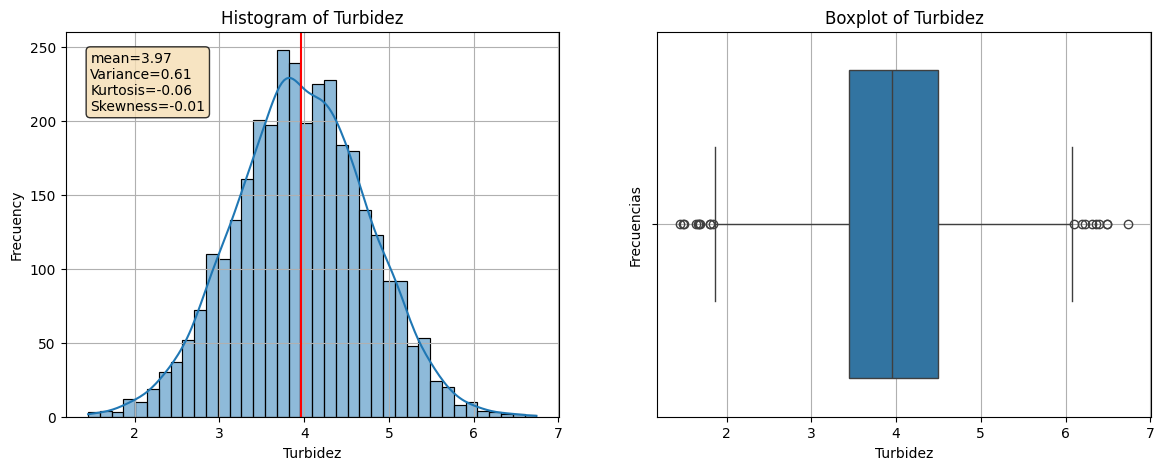

In [86]:
# Distribución (histograma) de la variable 'Turbidez'
histogram_box(df_knn, 'Turbidez')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* El comportamiento de la variable Turbidez es muy similar a una distribución normal.
* Se puede observar que la distribución se encuentra centrada en el valor de turbidez se encuentra muy por encima de lo aceptado por el GWP y por dabajo de lo que la OMS recomienda. No pobstante, la mayor parte de las muestras poseen un alto nivel de turbidez que limita con la impotabilidad del agua.

En general, a partir de las anteriores distribuciones podemos concluir lo siguiente:
1. Es muy probable encontrar que la mayoría de las muestras de agua sean consideradas como NO potables, ya que en general, la gran mayoría de muestras posee alta dureza, gran cantidad de sólidos, gran cantidad de sulfatos, alta conductividad, alta cantidad de Trihalomentanos y gran turbidez.
2. Todas las variables de nuestro dataset se comportan cercanamente a una distribución normal.
3. En general, las distribuciones posee un alto kurtosis lo cual permite que exísta una gran cantidad de outliers a ambos lados de las distribuciones.

### 2.3. Análisis de variables categóricas

---
Análisis de variables categóricas

---

Una vez analizadas las variables numéricas no ordinales y contínuas, procedamos a analizar que ocurre con las variables categóricas binarias.
A partir del siguiente plot, podemos observar que el dataset esta desbalanceado con respecto a la variable "Potabilidad". Esto afirma las conclusiones deducidas en la sección anterior de analisis univariado, donde vímos que si observamos el comportamiento de cada variable y lo comparamos con los valores límite de aceptación, nos es posible deducir que la gran mayoría de muestras de agua NO son potables. Concretamente, solo el 39% de las muestras son potables.

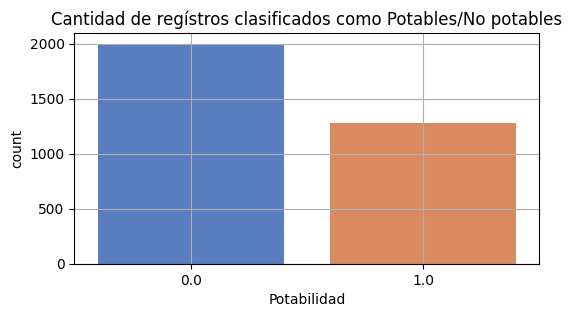

In [90]:
# Conteo de potabilidad y no potabilidad
plt.figure(figsize=(6,3))

sns.countplot(
    data = df_knn,
    x = 'Potabilidad',
    palette = 'muted'
)

plt.title('Cantidad de regístros clasificados como Potables/No potables')
plt.grid()
plt.show()

In [91]:
# Porcentaje de potabilidad
potabilidad = (df_knn[['Potabilidad']].value_counts()/len(df_knn))*100
potabilidad

Potabilidad
0.0            60.989011
1.0            39.010989
Name: count, dtype: float64

Debido a que deseamos asegurar que nuestros datos sean lo suficientemente apropiados para generar un modelo que capture la realidad de la clasificación del agua como potable o no pobale, vamos a realizar un pequeño preprocesamiento de nuestros datos de manera que generemos dos datasets nuevos que contenan una variable Potable balanceada. Concretamente, generaremos un dataset balanceado a partir de subsampleo y sobremuestreo mediante la técnica SMOTE.

In [94]:
sample_size = df['Potabilidad'].value_counts().values.min()
sample_size

array([1998, 1278])

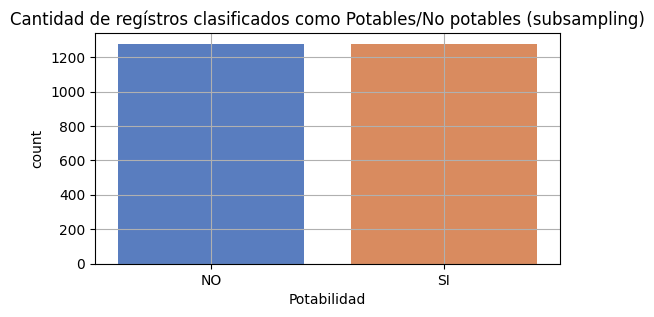

In [97]:
# Balanceo de los datos mediante submuestreo
random_seed = 42
sample_size = df['Potabilidad'].value_counts().values.min()

np.random.seed(42)

df_knn_no_enc = df_knn.drop(['Potabilidad'], axis=1)
df_knn_no_enc['Potabilidad'] = df['Potabilidad']

df_knn_sub = df_knn_no_enc.groupby('Potabilidad').apply(
    lambda grupo: grupo.sample(  min(len(grupo),sample_size) , random_state=random_seed )
)

# Conteo de potabilidad y no potabilidad bajo el metodo de submuestreo
plt.figure(figsize=(6,3))
sns.countplot(data=df_knn_sub,x='Potabilidad', palette = 'muted')
plt.title('Cantidad de regístros clasificados como Potables/No potables (subsampling)')
plt.grid()
plt.show()

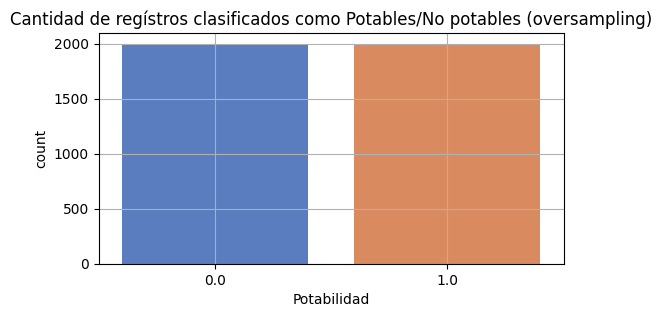

In [99]:
# Balanseo de los datos por metodo SMOTE
X = df_knn.drop(['Potabilidad'], axis=1)
y = df_knn['Potabilidad']

smote = SMOTE(sampling_strategy ='auto', random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_knn_over = pd.DataFrame(X_resampled, columns=X.columns)
df_knn_over['Potabilidad'] = y_resampled


# Conteo de potabilidad y no potabilidad bajo el metodo de submuestreo
plt.figure(figsize=(6,3))
sns.countplot(data=df_knn_over,x='Potabilidad', palette = 'muted')
plt.title('Cantidad de regístros clasificados como Potables/No potables (oversampling)')
plt.grid()
plt.show()

### 2.4. Análisis bivariado y de correlación

---
Análisis bivariado y de correlación

---

Gracias a que nuestro dataset posee solo 9 variables, nos es posible realizar  una mayor cantidad de comparaciones entre variables sin perder fácilmente el control ni el enfoque del análisis exploratorio. En la presente sección exploraremos los datos en búsqueda de patrones de relación directa entre pares de variables bien sea en forma de correlación (linealidad) o, patrones no lineales como clusters.

Para empezar, creemos un dataframe imputado sin codificación dummies o onehot.

In [ ]:
# Imputación de valores por medio del algoritmo KNN
df_knn_no_enc = df_knn.drop(['Potabilidad'], axis=1)
df_knn_no_enc['Potabilidad'] = df['Potabilidad']
df_knn_no_enc.head()

Una vez tenemos de nuevo nuestra variable categórica para que podamos usarla como criterio de segmentación de datos, procedemos a realizar un pairplot que nos permita ver las relaciones bivariadas entre nuestras variables segmentadas por potabilidad.

In [ ]:
# Paiplot entre todas las variables usando la temporada como criterio de etiquetado
plt.figure(figsize=(10,10))
...
plt.show()

A partir de la observación del pairplot anterior, podemos hacernos una perspectiva general de como los posibles pares de variables expresan patrones dentro de los datos. Podemos observar lo siguiente:
* Ningún scatter plot entre variables refleja una relación lineal o de correlación, de hecho, cada scatter plot corresponde a un conjunto de datos que se comportan similarmente a una distribución normal bidimensional de data.
*Si observamos la diagonal del pairplot la cual nos permite ver las distribuciones de las variables, vemos que en todos los casos la distribución del agua potable es inferior a la distribución del agua no potable, lo que indica que según todas las variables, la mayor cantidad de muestras de agua corresponden a aguas no potables.

Para evidenciar cuantitativamente la falta de correlación o colinealidad entre las variables, veremos a continuación una matriz de calor que refleja el coeficiente de correlación de Pearson entre variables. Vemos que casi todos los valores son cercanos a cero.

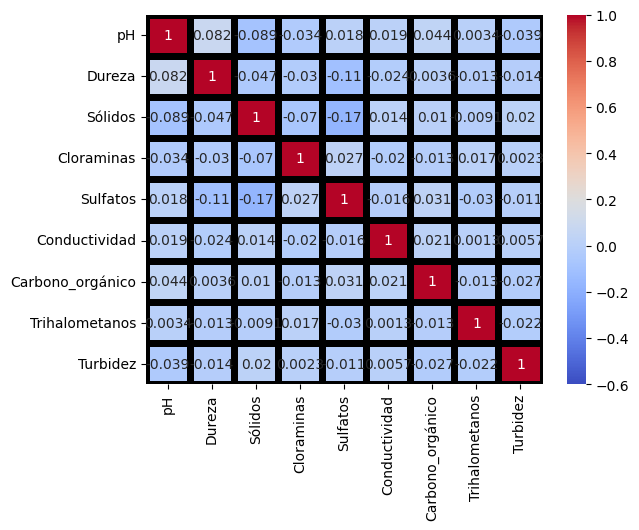

In [101]:
# Correlación entre variables
df_no_pot = df.drop(['Potabilidad'], axis=1)
corr_mat = df_no_pot.corr()
sns.heatmap(corr_mat,
            annot = True,
            cmap = 'coolwarm',
            linewidths = 5,
            linecolor = 'black',
            vmin = -0.6,
            vmax = 1,
            cbar = True )
plt.show()

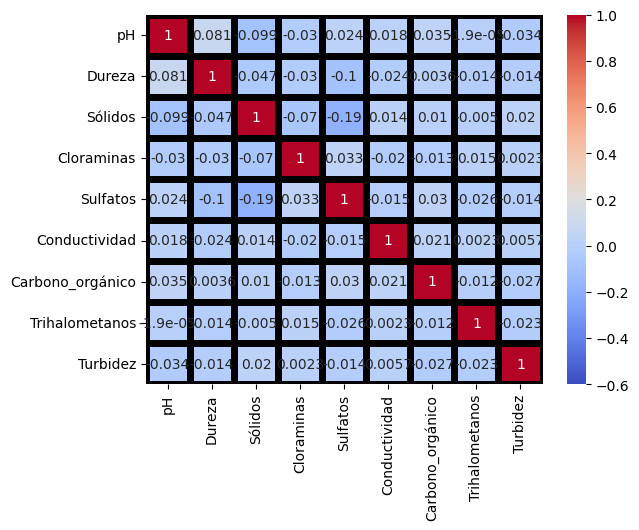

In [100]:
# Correlación entre variables
df_no_pot = df_knn.drop(['Potabilidad'], axis=1)
corr_mat = df_no_pot.corr()
sns.heatmap(corr_mat,
            annot = True,
            cmap = 'coolwarm',
            linewidths = 5,
            linecolor = 'black',
            vmin = -0.6,
            vmax = 1,
            cbar = True )
plt.show()

In [102]:
plt.figure(figsize=(10,10))
sns.pairplot(
    data = df_knn_no_enc,
    hue = 'Potabilidad',
    kind = 'scatter'
)

Output hidden; open in https://colab.research.google.com to view.

### 2.5. Análisis multivariado

---
Análisis multivariado

---

El presente conjunto de datos no permite un análisis multivariado tradicional en donde podamos usar diferentes variables categóricas para realizar segmentaciones en los datos, ya que de por si solo tenemos una única variable categórica.

# **Créditos**
---

**Docente:** Nicolás Castillo Ojeda

**Universidad Pedagógica y Tecnológica de Colombia** - *Diplomado en Data Science - Cohorte I - 2024*


---